In [11]:
import sys
sys.path.insert(0,"..")
from queuerious_detector.interpret import *
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# load dfs and embeddings
train_df = pd.read_csv("../data/processed/train_tickets.csv")
val_df = pd.read_csv("../data/processed/val_tickets.csv")
test_df = pd.read_csv("../data/processed/test_tickets.csv")

X_train = np.load("../data/processed/X_train_sbert.npy")
X_val = np.load("../data/processed/X_val_sbert.npy")
X_test = np.load("../data/processed/X_test_sbert.npy")

# encode labels
le = LabelEncoder()
y_train = le.fit_transform(train_df["queue_grouped"])
y_val = le.transform(val_df["queue_grouped"])
y_test = le.transform(test_df["queue_grouped"])

# scale embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# initialize the classifier
clf = SVC(class_weight="balanced", random_state=42)
clf.fit(X_train_scaled, y_train)

# predict on validation and test sets
y_val_pred = clf.predict(X_val_scaled)
y_test_pred = clf.predict(X_test_scaled)

print(
    "Validation Classification Report:\n",
    classification_report(y_val, y_val_pred, target_names=le.classes_),
)
print(
    "Test Classification Report:\n",
    classification_report(y_test, y_test_pred, target_names=le.classes_),
)

Validation Classification Report:
                                        precision    recall  f1-score   support

                 Billing and Payments       0.77      0.77      0.77       288
Customer Service, Returns & Exchanges       0.45      0.46      0.46       582
                      General Inquiry       0.42      0.46      0.44        41
                      Human Resources       0.40      0.72      0.51        60
                      Product Support       0.45      0.49      0.47       547
                  Sales and Pre-Sales       0.37      0.61      0.46        90
      Service Outages and Maintenance       0.56      0.80      0.66       120
               Technical & IT Support       0.70      0.58      0.63      1222

                             accuracy                           0.57      2950
                            macro avg       0.52      0.61      0.55      2950
                         weighted avg       0.59      0.57      0.57      2950

Test Classific

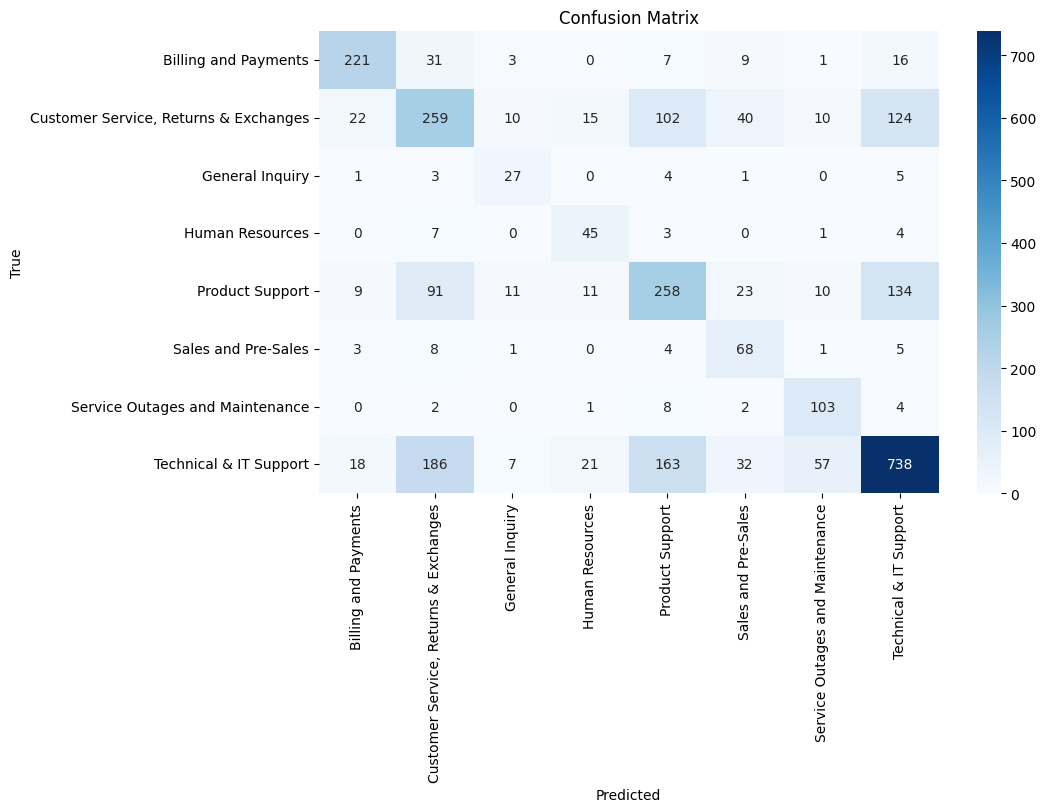

In [3]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

There are misclassifications across all the queues, but the model does well with the billing & payments queue.

In [4]:
#how manu samples in training set?
X_train_scaled.shape

(13765, 768)

In [ ]:
#parameter tuning with RandomizedSearchCV ~9-10 hours to complete
param_dist = {
    "C": np.logspace(-2, 2, 10),
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"] + list(np.logspace(-3, 1, 5)),
    "degree": [2, 3, 4]
}

rs = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1_weighted",
    verbose=2,
    random_state=42,
)

#subset the training data to speed up the search
subset_idx = np.random.choice(len(X_train_scaled), size=6500, replace=False)
rs.fit(X_train_scaled[subset_idx], y_train[subset_idx]) 

print("Best parameters found:", rs.best_params_)
print("Best weighted F1 score:", rs.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END C=12.915496650148826, degree=4, gamma=0.1, kernel=poly; total time= 1.2min
[CV] END C=12.915496650148826, degree=4, gamma=0.1, kernel=poly; total time= 1.1min
[CV] END C=12.915496650148826, degree=4, gamma=0.1, kernel=poly; total time= 1.1min
[CV] END C=0.21544346900318834, degree=4, gamma=0.1, kernel=rbf; total time= 1.4min
[CV] END C=0.21544346900318834, degree=4, gamma=0.1, kernel=rbf; total time= 1.4min
[CV] END C=0.21544346900318834, degree=4, gamma=0.1, kernel=rbf; total time= 1.4min
[CV] END C=35.93813663804626, degree=4, gamma=0.001, kernel=linear; total time=97.1min
[CV] END C=35.93813663804626, degree=4, gamma=0.001, kernel=linear; total time=19.2min
[CV] END C=35.93813663804626, degree=4, gamma=0.001, kernel=linear; total time=13.3min
[CV] END C=0.21544346900318834, degree=3, gamma=auto, kernel=linear; total time=  23.0s
[CV] END C=0.21544346900318834, degree=3, gamma=auto, kernel=linear; total time=  21.8

In [7]:
#initialize the best model
best_model = rs.best_estimator_

#fit on the full training set
best_model.fit(X_train_scaled, y_train)

#predict on validation and test sets
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

print(
    "Validation Classification Report:\n",
    classification_report(y_val, y_val_pred, target_names=le.classes_),
)
print(
    "Test Classification Report:\n",
    classification_report(y_test, y_test_pred, target_names=le.classes_),
)

Validation Classification Report:
                                        precision    recall  f1-score   support

                 Billing and Payments       0.90      0.85      0.88       288
Customer Service, Returns & Exchanges       0.75      0.73      0.74       582
                      General Inquiry       0.89      0.39      0.54        41
                      Human Resources       0.83      0.67      0.74        60
                      Product Support       0.77      0.70      0.73       547
                  Sales and Pre-Sales       0.85      0.61      0.71        90
      Service Outages and Maintenance       0.90      0.71      0.79       120
               Technical & IT Support       0.79      0.89      0.84      1222

                             accuracy                           0.79      2950
                            macro avg       0.83      0.69      0.75      2950
                         weighted avg       0.79      0.79      0.79      2950

Test Classific

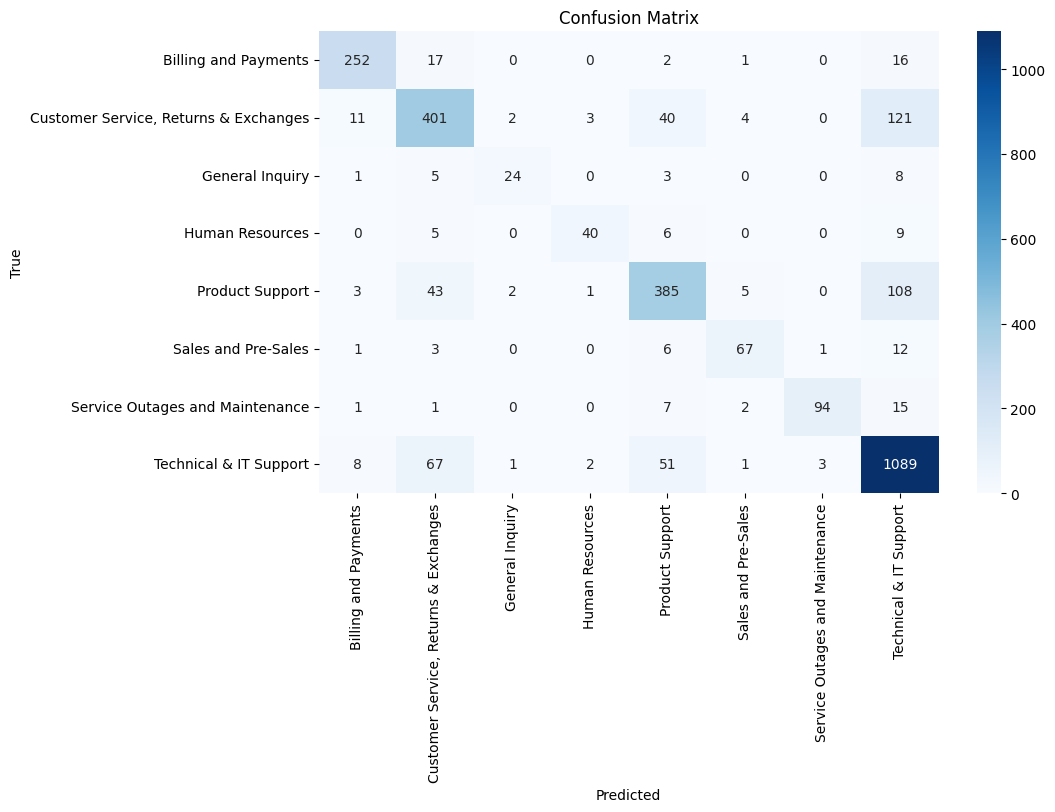

In [8]:
#confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap="Blues",
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The tuned model has an improved weighted `f1` score from .59 to .80 in the test set. Best performance comes from the Billing and Payments class with an F1 score of .89. After reviewing the validation and test report, we can see that the model generalizes well since we get weighted `F1` scores of .79 and .80, respectively.

In [12]:
show_nearest_tickets(
    query_index=42, 
    X_query=X_test_scaled, 
    X_ref=X_train_scaled, 
    df_query=test_df, 
    df_ref=train_df,
    n_neighbors=5,
    top_n=3
)

QUERY TICKET:
Multiple hospital system applications, such as <NAME>, WhatsApp Desktop, and network switches, experienced outages and malfunctions, potentially leading to security vulnerabilities and network failures. Initial troubleshooting steps included rebooting systems, conducting network diagnostics, and performing security scans. Since the issue persists, urgent escalation is required. An investigation is necessary to identify the root cause and implement an appropriate solution. Your assistance and guidance from the team would be appreciated to resolve this matter.
Top 3 Most Similar Tickets in Reference Set (Sorted from Least to Most Similar):
Neighbor #1
Distance: 0.309
True Label: Technical & IT Support
Text Preview:
Report on Security Issue in Hospital IT Healthcare providers are experiencing multiple connectivity 
Neighbor #2
Distance: 0.306
True Label: Technical & IT Support
Text Preview:
Issue with Hospital Systems The hospital's systems have undergone a breach that impac